<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [34]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [35]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [36]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [37]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [38]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [39]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  print((1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]))
  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

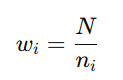

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [40]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [41]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 3:
    googlenet = models.googlenet(weights="IMAGENET1K_V1")
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 4:
    efficientnet = models.efficientnet_b3(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 5:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  elif numero_model == 6:

    resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass.fc.in_features
    resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass,loss_fn

  elif numero_model == 7:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 8:

    googlenetmulticlass = models.googlenet(weights="IMAGENET1K_V1")

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenetmulticlass,loss_fn

  elif numero_model == 9:

    efficientnetmulticlass = models.efficientnet_b3(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.CrossEntropyLoss(pos_weight=pos_weight)

    num_features = efficientnetmulticlass.fc.in_features
    efficientnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

    return efficientnet,loss_fn



In [42]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [43]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [44]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [45]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 10
  requerit = 0.015
  last_f1 = 0

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_f1 + requerit > train_f1:
            torch.save(model.state_dict(), 'best_model.pt')
            print("Early Stopping, no hem pujat ni un 2% d'f1-score respecte 10 èpoques!!")
            break
        else:
          interval = 10
          last_f1 = train_f1


In [46]:
def test(model,dataloader,weights_dir,loss_fn,device):
  model.load_state_dict(torch.load(weights_dir))
  test_acc,test_f1,test_recall,test_precision,test_loss  = validate(model,loss_fn,dataloader,device)

  if WEIGHTSANDBIASES:
    test_metrics = {"test/test_loss": test_loss/len(dataloader),
                      "test/test_acc":test_acc/len(dataloader),
                      "test/test_f1":test_f1/len(dataloader),
                      "test/test_recall": test_recall/len(dataloader),
                      "test/test_precision": test_precision/len(dataloader)}

    wandb.log({**test_metrics})

In [47]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet': 1,'resnet152':2,'googlenet':3,'efficientnet':4,'alexnetmulticlass':5,'resnet50multiclass':6,'resnet150multiclass':7,'googlenetmulticlass':8,'efficientnetmulticlass':9}
MODEL = architectures['efficientnet']

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 50
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

#get_weights()
increment = 1.0
binary_weights, multiple_weights = get_weights()

if MODEL < 5:
  WEIGHTS = [binary_weights]
  print(WEIGHTS)
else:
  WEIGHTS = [multiple_weights]


learning_rate  = 1e-5

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-ResnetBinary','Ham1000-Resnet152Binary','Ham10000-GoogleNetBinary','Ham10000-EfficientNetBinary',
               'Ham10000-AlexnetMulticlass','Ham10000ResnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-GoogleNetMulticlass','Ham10000-EfficientNetMulticlass']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
  test(model,test_loader,"/content/best_model.pt",loss_fn,device)
  wandb.finish()

0    5363
1     891
2     879
3     411
4     261
5     114
6      92
Name: count, dtype: int64
8011
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
2.845929572315279
[2.845929572315279]


{'epochs': 50, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [2.845929572315279]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.8881887311479485
Accuracy train epoch: 1  train_acc: 0.685530604853314
F1 train epoch: 1  train_f1: 0.7090584159878861
Recall train epoch: 1  train_recall: 0.685530604853314


Pèrdua validació epoch: 1  val_loss: 0.8991205003112555
Accuracy val epoch: 1  val_acc: 0.769921875
F1 val epoch: 1  val_f1: 0.7868138863341478
Recall val epoch: 1  val_recall: 0.769921875
Recall val epoch: 1  val_precision: 0.8212206967674376


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.7630995146306863
Accuracy train epoch: 2  train_acc: 0.7676000543281419
F1 train epoch: 2  train_f1: 0.7866527035482213
Recall train epoch: 2  train_recall: 0.7676000543281419


Pèrdua validació epoch: 2  val_loss: 0.9771558996289968
Accuracy val epoch: 2  val_acc: 0.7671875
F1 val epoch: 2  val_f1: 0.7878197885058446
Recall val epoch: 2  val_recall: 0.7671875
Recall val epoch: 2  val_precision: 0.8492497805953094


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.6551569804727319
Accuracy train epoch: 3  train_acc: 0.7693430822165882
F1 train epoch: 3  train_f1: 0.7922636664437384
Recall train epoch: 3  train_recall: 0.7693430822165882


Pèrdua validació epoch: 3  val_loss: 0.8037715433165431
Accuracy val epoch: 3  val_acc: 0.7787109375
F1 val epoch: 3  val_f1: 0.7982037648401117
Recall val epoch: 3  val_recall: 0.7787109375
Recall val epoch: 3  val_precision: 0.8606447136216162


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.6049303089480002
Accuracy train epoch: 4  train_acc: 0.7806614451285766
F1 train epoch: 4  train_f1: 0.8023877413647841
Recall train epoch: 4  train_recall: 0.7806614451285766


Pèrdua validació epoch: 4  val_loss: 1.135800982825458
Accuracy val epoch: 4  val_acc: 0.7875
F1 val epoch: 4  val_f1: 0.8078551174269812
Recall val epoch: 4  val_recall: 0.7875
Recall val epoch: 4  val_precision: 0.8635130096680349


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.5603949372986873
Accuracy train epoch: 5  train_acc: 0.8053015211879754
F1 train epoch: 5  train_f1: 0.8238062153335385
Recall train epoch: 5  train_recall: 0.8053015211879754


Pèrdua validació epoch: 5  val_loss: 0.6413917886093259
Accuracy val epoch: 5  val_acc: 0.8220703125
F1 val epoch: 5  val_f1: 0.8360783986759932
Recall val epoch: 5  val_recall: 0.8220703125
Recall val epoch: 5  val_precision: 0.8700344012460879


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.5460746937776467
Accuracy train epoch: 6  train_acc: 0.8160086925027163
F1 train epoch: 6  train_f1: 0.8326675629577873
Recall train epoch: 6  train_recall: 0.8160086925027163


Pèrdua validació epoch: 6  val_loss: 1.0193809745833278
Accuracy val epoch: 6  val_acc: 0.8126953125
F1 val epoch: 6  val_f1: 0.8269487837210682
Recall val epoch: 6  val_recall: 0.8126953125
Recall val epoch: 6  val_precision: 0.8684028854220521


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.5264726431958704
Accuracy train epoch: 7  train_acc: 0.8233543100325968
F1 train epoch: 7  train_f1: 0.8391384209881098
Recall train epoch: 7  train_recall: 0.8233543100325968


Pèrdua validació epoch: 7  val_loss: 0.530962707940489
Accuracy val epoch: 7  val_acc: 0.840625
F1 val epoch: 7  val_f1: 0.8509091399135931
Recall val epoch: 7  val_recall: 0.840625
Recall val epoch: 7  val_precision: 0.8776694839621554


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.5105162304473588
Accuracy train epoch: 8  train_acc: 0.8282098877218399
F1 train epoch: 8  train_f1: 0.8441979154656688
Recall train epoch: 8  train_recall: 0.8282098877218399


Pèrdua validació epoch: 8  val_loss: 2.0413692137226462
Accuracy val epoch: 8  val_acc: 0.83359375
F1 val epoch: 8  val_f1: 0.8449473783086049
Recall val epoch: 8  val_recall: 0.83359375
Recall val epoch: 8  val_precision: 0.8762833246205873


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.49828848124025354
Accuracy train epoch: 9  train_acc: 0.8366760231800072
F1 train epoch: 9  train_f1: 0.8496725662680092
Recall train epoch: 9  train_recall: 0.8366760231800072


Pèrdua validació epoch: 9  val_loss: 0.5314350600820035
Accuracy val epoch: 9  val_acc: 0.8408203125
F1 val epoch: 9  val_f1: 0.8526507205126895
Recall val epoch: 9  val_recall: 0.8408203125
Recall val epoch: 9  val_precision: 0.8803134934962383


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.4859199767331203
Accuracy train epoch: 10  train_acc: 0.8436481347337921
F1 train epoch: 10  train_f1: 0.8559955802321357
Recall train epoch: 10  train_recall: 0.8436481347337921


Pèrdua validació epoch: 10  val_loss: 0.5132638053037226
Accuracy val epoch: 10  val_acc: 0.840625
F1 val epoch: 10  val_f1: 0.8513825971046246
Recall val epoch: 10  val_recall: 0.840625
Recall val epoch: 10  val_precision: 0.8786355413553053


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.4633331568948776
Accuracy train epoch: 11  train_acc: 0.8494770916334662
F1 train epoch: 11  train_f1: 0.8624948262111254
Recall train epoch: 11  train_recall: 0.8494770916334662


Pèrdua validació epoch: 11  val_loss: 0.5437246500514448
Accuracy val epoch: 11  val_acc: 0.8376953125
F1 val epoch: 11  val_f1: 0.8479928676317375
Recall val epoch: 11  val_recall: 0.8376953125
Recall val epoch: 11  val_precision: 0.8714999618136948


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.4533680635263245
Accuracy train epoch: 12  train_acc: 0.8521255885548714
F1 train epoch: 12  train_f1: 0.8635466550282324
Recall train epoch: 12  train_recall: 0.8521255885548714


Pèrdua validació epoch: 12  val_loss: 0.5078992517665029
Accuracy val epoch: 12  val_acc: 0.841796875
F1 val epoch: 12  val_f1: 0.853278753586262
Recall val epoch: 12  val_recall: 0.841796875
Recall val epoch: 12  val_precision: 0.8837986371947767


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.4474765206594391
Accuracy train epoch: 13  train_acc: 0.8598220753350235
F1 train epoch: 13  train_f1: 0.8702952345992122
Recall train epoch: 13  train_recall: 0.8598220753350235


Pèrdua validació epoch: 13  val_loss: 0.8618481061421335
Accuracy val epoch: 13  val_acc: 0.834765625
F1 val epoch: 13  val_f1: 0.8455159504882642
Recall val epoch: 13  val_recall: 0.834765625
Recall val epoch: 13  val_precision: 0.8751359294948954


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.4398932319238366
Accuracy train epoch: 14  train_acc: 0.8590977001086563
F1 train epoch: 14  train_f1: 0.870961067831991
Recall train epoch: 14  train_recall: 0.8590977001086563


Pèrdua validació epoch: 14  val_loss: 0.5364174754358828
Accuracy val epoch: 14  val_acc: 0.840234375
F1 val epoch: 14  val_f1: 0.8490762128349878
Recall val epoch: 14  val_recall: 0.840234375
Recall val epoch: 14  val_precision: 0.8701991427999981


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.43076150724849854
Accuracy train epoch: 15  train_acc: 0.8629459434987323
F1 train epoch: 15  train_f1: 0.8736925480844924
Recall train epoch: 15  train_recall: 0.8629459434987323


Pèrdua validació epoch: 15  val_loss: 0.6528659481555223
Accuracy val epoch: 15  val_acc: 0.84453125
F1 val epoch: 15  val_f1: 0.8530089024518948
Recall val epoch: 15  val_recall: 0.84453125
Recall val epoch: 15  val_precision: 0.8765441898596195


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.4240204252569799
Accuracy train epoch: 16  train_acc: 0.8635684534588917
F1 train epoch: 16  train_f1: 0.8750569799262432
Recall train epoch: 16  train_recall: 0.8635684534588917


Pèrdua validació epoch: 16  val_loss: 0.48407359793782234
Accuracy val epoch: 16  val_acc: 0.843359375
F1 val epoch: 16  val_f1: 0.8523453161368226
Recall val epoch: 16  val_recall: 0.843359375
Recall val epoch: 16  val_precision: 0.87182449372412


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.41658280694864663
Accuracy train epoch: 17  train_acc: 0.8731551068453459
F1 train epoch: 17  train_f1: 0.8819419855710636
Recall train epoch: 17  train_recall: 0.8731551068453459


Pèrdua validació epoch: 17  val_loss: 0.6499775568954647
Accuracy val epoch: 17  val_acc: 0.8416015625
F1 val epoch: 17  val_f1: 0.8515018445556106
Recall val epoch: 17  val_recall: 0.8416015625
Recall val epoch: 17  val_precision: 0.8784737038947


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.4079180320064385
Accuracy train epoch: 18  train_acc: 0.8729061028612821
F1 train epoch: 18  train_f1: 0.8821579769684326
Recall train epoch: 18  train_recall: 0.8729061028612821


Pèrdua validació epoch: 18  val_loss: 0.8862082539126277
Accuracy val epoch: 18  val_acc: 0.8453125
F1 val epoch: 18  val_f1: 0.8575005312569752
Recall val epoch: 18  val_recall: 0.8453125
Recall val epoch: 18  val_precision: 0.8832603929230415


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.39452234611093284
Accuracy train epoch: 19  train_acc: 0.8805233611010503
F1 train epoch: 19  train_f1: 0.8884377073721446
Recall train epoch: 19  train_recall: 0.8805233611010503


Pèrdua validació epoch: 19  val_loss: 0.7160404725000262
Accuracy val epoch: 19  val_acc: 0.841015625
F1 val epoch: 19  val_f1: 0.8505051139107999
Recall val epoch: 19  val_recall: 0.841015625
Recall val epoch: 19  val_precision: 0.87651236336856


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.39116603278543843
Accuracy train epoch: 20  train_acc: 0.8777503621876132
F1 train epoch: 20  train_f1: 0.8872184374463805
Recall train epoch: 20  train_recall: 0.8777503621876132


Pèrdua validació epoch: 20  val_loss: 0.7599485269747674
Accuracy val epoch: 20  val_acc: 0.840234375
F1 val epoch: 20  val_f1: 0.8490912969039137
Recall val epoch: 20  val_recall: 0.840234375
Recall val epoch: 20  val_precision: 0.8805127506718744


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.37717311636385215
Accuracy train epoch: 21  train_acc: 0.8812364179645056
F1 train epoch: 21  train_f1: 0.8899530308864751
Recall train epoch: 21  train_recall: 0.8812364179645056


Pèrdua validació epoch: 21  val_loss: 1.21122966427356
Accuracy val epoch: 21  val_acc: 0.8544921875
F1 val epoch: 21  val_f1: 0.8619991674337533
Recall val epoch: 21  val_recall: 0.8544921875
Recall val epoch: 21  val_precision: 0.8778226932228642


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.367843659453658
Accuracy train epoch: 22  train_acc: 0.8862504527345164
F1 train epoch: 22  train_f1: 0.8943496845761846
Recall train epoch: 22  train_recall: 0.8862504527345164


Pèrdua validació epoch: 22  val_loss: 0.7586258035153151
Accuracy val epoch: 22  val_acc: 0.855078125
F1 val epoch: 22  val_f1: 0.8629212896676006
Recall val epoch: 22  val_recall: 0.855078125
Recall val epoch: 22  val_precision: 0.8821260605151422


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.36622346216345214
Accuracy train epoch: 23  train_acc: 0.8887178558493299
F1 train epoch: 23  train_f1: 0.8978335088297545
Recall train epoch: 23  train_recall: 0.8887178558493299


Pèrdua validació epoch: 23  val_loss: 0.4546924317255616
Accuracy val epoch: 23  val_acc: 0.861328125
F1 val epoch: 23  val_f1: 0.8677207939112052
Recall val epoch: 23  val_recall: 0.861328125
Recall val epoch: 23  val_precision: 0.8830421091104386


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.3541364050600158
Accuracy train epoch: 24  train_acc: 0.8951693227091634
F1 train epoch: 24  train_f1: 0.9027649383780835
Recall train epoch: 24  train_recall: 0.8951693227091634


Pèrdua validació epoch: 24  val_loss: 0.75215571699664
Accuracy val epoch: 24  val_acc: 0.8552734375
F1 val epoch: 24  val_f1: 0.8618160626378515
Recall val epoch: 24  val_recall: 0.8552734375
Recall val epoch: 24  val_precision: 0.8818785840329658


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.34575857958233214
Accuracy train epoch: 25  train_acc: 0.8965501629844259
F1 train epoch: 25  train_f1: 0.9037269878377757
Recall train epoch: 25  train_recall: 0.8965501629844259


Pèrdua validació epoch: 25  val_loss: 0.6913344394415617
Accuracy val epoch: 25  val_acc: 0.8662109375
F1 val epoch: 25  val_f1: 0.8719205986954504
Recall val epoch: 25  val_recall: 0.8662109375
Recall val epoch: 25  val_precision: 0.8862072967492107


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.3296842349181137
Accuracy train epoch: 26  train_acc: 0.9005342267294458
F1 train epoch: 26  train_f1: 0.9076096234825521
Recall train epoch: 26  train_recall: 0.9005342267294458


Pèrdua validació epoch: 26  val_loss: 0.4530662978067994
Accuracy val epoch: 26  val_acc: 0.8642578125
F1 val epoch: 26  val_f1: 0.87246519840874
Recall val epoch: 26  val_recall: 0.8642578125
Recall val epoch: 26  val_precision: 0.8957996250381185


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.3392350788551023
Accuracy train epoch: 27  train_acc: 0.8975574972835929
F1 train epoch: 27  train_f1: 0.9041777952770895
Recall train epoch: 27  train_recall: 0.8975574972835929


Pèrdua validació epoch: 27  val_loss: 0.43016904685646296
Accuracy val epoch: 27  val_acc: 0.869921875
F1 val epoch: 27  val_f1: 0.8764495272636679
Recall val epoch: 27  val_recall: 0.869921875
Recall val epoch: 27  val_precision: 0.895270750092026


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.3253422206735231
Accuracy train epoch: 28  train_acc: 0.8995268924302788
F1 train epoch: 28  train_f1: 0.9065461410928731
Recall train epoch: 28  train_recall: 0.8995268924302788


Pèrdua validació epoch: 28  val_loss: 0.43316610157489777
Accuracy val epoch: 28  val_acc: 0.871875
F1 val epoch: 28  val_f1: 0.8749331298108005
Recall val epoch: 28  val_recall: 0.871875
Recall val epoch: 28  val_precision: 0.8875796807515322


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.3120151710997065
Accuracy train epoch: 29  train_acc: 0.9061481347337921
F1 train epoch: 29  train_f1: 0.9129823785433431
Recall train epoch: 29  train_recall: 0.9061481347337921


Pèrdua validació epoch: 29  val_loss: 0.4506673503201455
Accuracy val epoch: 29  val_acc: 0.8779296875
F1 val epoch: 29  val_f1: 0.8816560918012063
Recall val epoch: 29  val_recall: 0.8779296875
Recall val epoch: 29  val_precision: 0.8937305765805299


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.29808512929663716
Accuracy train epoch: 30  train_acc: 0.9103698840999638
F1 train epoch: 30  train_f1: 0.9165874661116389
Recall train epoch: 30  train_recall: 0.9103698840999638


Pèrdua validació epoch: 30  val_loss: 0.4237205795943737
Accuracy val epoch: 30  val_acc: 0.8740234375
F1 val epoch: 30  val_f1: 0.8775131546984191
Recall val epoch: 30  val_recall: 0.8740234375
Recall val epoch: 30  val_precision: 0.8941257316373147


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.2922979709636643
Accuracy train epoch: 31  train_acc: 0.9144784498370155
F1 train epoch: 31  train_f1: 0.9196517304545234
Recall train epoch: 31  train_recall: 0.9144784498370155


Pèrdua validació epoch: 31  val_loss: 0.4281302550807595
Accuracy val epoch: 31  val_acc: 0.871875
F1 val epoch: 31  val_f1: 0.8767457524266918
Recall val epoch: 31  val_recall: 0.871875
Recall val epoch: 31  val_precision: 0.8930537377512155


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.2929125746704668
Accuracy train epoch: 32  train_acc: 0.9078798442593263
F1 train epoch: 32  train_f1: 0.9138116995708003
Recall train epoch: 32  train_recall: 0.9078798442593263


Pèrdua validació epoch: 32  val_loss: 0.43688067188486457
Accuracy val epoch: 32  val_acc: 0.8767578125
F1 val epoch: 32  val_f1: 0.881144649596436
Recall val epoch: 32  val_recall: 0.8767578125
Recall val epoch: 32  val_precision: 0.8937585988638976


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.27920785697689093
Accuracy train epoch: 33  train_acc: 0.9190963419051068
F1 train epoch: 33  train_f1: 0.9240215785229284
Recall train epoch: 33  train_recall: 0.9190963419051068


Pèrdua validació epoch: 33  val_loss: 0.421207093866542
Accuracy val epoch: 33  val_acc: 0.8759765625
F1 val epoch: 33  val_f1: 0.8816115350705833
Recall val epoch: 33  val_recall: 0.8759765625
Recall val epoch: 33  val_precision: 0.8963683274843461


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.2741178780705093
Accuracy train epoch: 34  train_acc: 0.9188360195581311
F1 train epoch: 34  train_f1: 0.9244349831791148
Recall train epoch: 34  train_recall: 0.9188360195581311


Pèrdua validació epoch: 34  val_loss: 0.4491842593997717
Accuracy val epoch: 34  val_acc: 0.88671875
F1 val epoch: 34  val_f1: 0.8873705457895497
Recall val epoch: 34  val_recall: 0.88671875
Recall val epoch: 34  val_precision: 0.8942504844505991


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.28127229424468075
Accuracy train epoch: 35  train_acc: 0.9158592901122782
F1 train epoch: 35  train_f1: 0.9219643442947679
Recall train epoch: 35  train_recall: 0.9158592901122782


Pèrdua validació epoch: 35  val_loss: 0.4147463724948466
Accuracy val epoch: 35  val_acc: 0.880859375
F1 val epoch: 35  val_f1: 0.8844537831095899
Recall val epoch: 35  val_recall: 0.880859375
Recall val epoch: 35  val_precision: 0.8979381551409843


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.2660425972950411
Accuracy train epoch: 36  train_acc: 0.9221862549800797
F1 train epoch: 36  train_f1: 0.9269067748597969
Recall train epoch: 36  train_recall: 0.9221862549800797


Pèrdua validació epoch: 36  val_loss: 0.41841668216511607
Accuracy val epoch: 36  val_acc: 0.8833984375
F1 val epoch: 36  val_f1: 0.889411402364832
Recall val epoch: 36  val_recall: 0.8833984375
Recall val epoch: 36  val_precision: 0.9068992496219983


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.25816835819250084
Accuracy train epoch: 37  train_acc: 0.9240651032234698
F1 train epoch: 37  train_f1: 0.9290162290585767
Recall train epoch: 37  train_recall: 0.9240651032234698


Pèrdua validació epoch: 37  val_loss: 0.41910532489418983
Accuracy val epoch: 37  val_acc: 0.88671875
F1 val epoch: 37  val_f1: 0.8915976966092438
Recall val epoch: 37  val_recall: 0.88671875
Recall val epoch: 37  val_precision: 0.9043936909177652


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.26504335404036056
Accuracy train epoch: 38  train_acc: 0.9172061752988048
F1 train epoch: 38  train_f1: 0.9229491943364955
Recall train epoch: 38  train_recall: 0.9172061752988048


Pèrdua validació epoch: 38  val_loss: 0.4292308557778597
Accuracy val epoch: 38  val_acc: 0.8982421875
F1 val epoch: 38  val_f1: 0.9008765985505722
Recall val epoch: 38  val_recall: 0.8982421875
Recall val epoch: 38  val_precision: 0.9109055138169364


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.24480596077869612
Accuracy train epoch: 39  train_acc: 0.9302902028250634
F1 train epoch: 39  train_f1: 0.9349042437176159
Recall train epoch: 39  train_recall: 0.9302902028250634


Pèrdua validació epoch: 39  val_loss: 0.4149543587118387
Accuracy val epoch: 39  val_acc: 0.896484375
F1 val epoch: 39  val_f1: 0.9001250882248666
Recall val epoch: 39  val_recall: 0.896484375
Recall val epoch: 39  val_precision: 0.9147564103819243


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.23952969534701085
Accuracy train epoch: 40  train_acc: 0.9316936798261499
F1 train epoch: 40  train_f1: 0.9357052892252976
Recall train epoch: 40  train_recall: 0.9316936798261499


Pèrdua validació epoch: 40  val_loss: 0.4149552946910262
Accuracy val epoch: 40  val_acc: 0.884375
F1 val epoch: 40  val_f1: 0.8898586719134671
Recall val epoch: 40  val_recall: 0.884375
Recall val epoch: 40  val_precision: 0.9066131166303126


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.24922124762459105
Accuracy train epoch: 41  train_acc: 0.9273021550162984
F1 train epoch: 41  train_f1: 0.9318872676706349
Recall train epoch: 41  train_recall: 0.9273021550162984


Pèrdua validació epoch: 41  val_loss: 0.430238613858819
Accuracy val epoch: 41  val_acc: 0.88984375
F1 val epoch: 41  val_f1: 0.891959669173504
Recall val epoch: 41  val_recall: 0.88984375
Recall val epoch: 41  val_precision: 0.902584117562251


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.2254976879404598
Accuracy train epoch: 42  train_acc: 0.9354061028612821
F1 train epoch: 42  train_f1: 0.9391261387978093
Recall train epoch: 42  train_recall: 0.9354061028612821


Pèrdua validació epoch: 42  val_loss: 0.45397913560736924
Accuracy val epoch: 42  val_acc: 0.8892578125
F1 val epoch: 42  val_f1: 0.8905755238579082
Recall val epoch: 42  val_recall: 0.8892578125
Recall val epoch: 42  val_precision: 0.9010620211183015


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.2268718646475637
Accuracy train epoch: 43  train_acc: 0.9357569721115537
F1 train epoch: 43  train_f1: 0.9394070843916918
Recall train epoch: 43  train_recall: 0.9357569721115537


Pèrdua validació epoch: 43  val_loss: 0.44664964522235096
Accuracy val epoch: 43  val_acc: 0.8947265625
F1 val epoch: 43  val_f1: 0.8981509463844161
Recall val epoch: 43  val_recall: 0.8947265625
Recall val epoch: 43  val_precision: 0.9101010052978331


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.2306516850107457
Accuracy train epoch: 44  train_acc: 0.932644422310757
F1 train epoch: 44  train_f1: 0.9368847400393393
Recall train epoch: 44  train_recall: 0.932644422310757


Pèrdua validació epoch: 44  val_loss: 0.41465863352641463
Accuracy val epoch: 44  val_acc: 0.904296875
F1 val epoch: 44  val_f1: 0.9064197389840318
Recall val epoch: 44  val_recall: 0.904296875
Recall val epoch: 44  val_precision: 0.9148067910209128


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.21178651580297614
Accuracy train epoch: 45  train_acc: 0.9392430278884463
F1 train epoch: 45  train_f1: 0.94249814538731
Recall train epoch: 45  train_recall: 0.9392430278884463


Pèrdua validació epoch: 45  val_loss: 0.41643916768953204
Accuracy val epoch: 45  val_acc: 0.8904296875
F1 val epoch: 45  val_f1: 0.8951960669434642
Recall val epoch: 45  val_recall: 0.8904296875
Recall val epoch: 45  val_precision: 0.911318608587645


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.21017555156314516
Accuracy train epoch: 46  train_acc: 0.9379980079681275
F1 train epoch: 46  train_f1: 0.9415692713601592
Recall train epoch: 46  train_recall: 0.9379980079681275


Pèrdua validació epoch: 46  val_loss: 0.41469910251908004
Accuracy val epoch: 46  val_acc: 0.896484375
F1 val epoch: 46  val_f1: 0.8999384100210146
Recall val epoch: 46  val_recall: 0.896484375
Recall val epoch: 46  val_precision: 0.9120229192104192


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.1932345890399232
Accuracy train epoch: 47  train_acc: 0.9461019558131112
F1 train epoch: 47  train_f1: 0.9486080476895028
Recall train epoch: 47  train_recall: 0.9461019558131112


Pèrdua validació epoch: 47  val_loss: 0.42262268671765924
Accuracy val epoch: 47  val_acc: 0.9001953125
F1 val epoch: 47  val_f1: 0.9008618629565834
Recall val epoch: 47  val_recall: 0.9001953125
Recall val epoch: 47  val_precision: 0.908947157270442


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.21481157028194206
Accuracy train epoch: 48  train_acc: 0.9368888084027526
F1 train epoch: 48  train_f1: 0.9407290155528314
Recall train epoch: 48  train_recall: 0.9368888084027526


Pèrdua validació epoch: 48  val_loss: 0.40480968705378473
Accuracy val epoch: 48  val_acc: 0.9001953125
F1 val epoch: 48  val_f1: 0.9027060637886722
Recall val epoch: 48  val_recall: 0.9001953125
Recall val epoch: 48  val_precision: 0.9119897435840881


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.20115780192186158
Accuracy train epoch: 49  train_acc: 0.940499366171677
F1 train epoch: 49  train_f1: 0.9437959133413445
Recall train epoch: 49  train_recall: 0.940499366171677


Pèrdua validació epoch: 49  val_loss: 0.4370398230385035
Accuracy val epoch: 49  val_acc: 0.9046875
F1 val epoch: 49  val_f1: 0.9062797537100539
Recall val epoch: 49  val_recall: 0.9046875
Recall val epoch: 49  val_precision: 0.9200618279582141


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.184765253520285
Accuracy train epoch: 50  train_acc: 0.9474827960883737
F1 train epoch: 50  train_f1: 0.950582439612905
Recall train epoch: 50  train_recall: 0.9474827960883737


Pèrdua validació epoch: 50  val_loss: 0.4228703314438462
Accuracy val epoch: 50  val_acc: 0.90234375
F1 val epoch: 50  val_f1: 0.9046361364434563
Recall val epoch: 50  val_recall: 0.90234375
Recall val epoch: 50  val_precision: 0.915190463712238
Early Stopping, no hem pujat ni un 2% d'f1-score respecte 10 èpoques!!


<ipython-input-46-9bf2008f8092>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_dir))


test/test_acc,▁
test/test_f1,▁
test/test_loss,▁
test/test_precision,▁
test/test_recall,▁
train/train_acc,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇███████
train/train_f1,▁▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇███████
train/train_loss,█▇▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train/train_precision,▁▂▂▃▃▄▄▄▅▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
train/train_recall,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
val/val_acc,▁▁▂▂▄▅▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██▇▇▇▇████
